In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
# Conventional demodulation
def demapper_sym(symbols_I, symbols_Q, Ns, threshold = 2.0):
   symbol = []
   for i in range(Ns):
        if symbols_I[i] <= -threshold and symbols_Q[i] >= threshold: #-3+3j
            symbol.append(0)
        elif symbols_I[i] <= -threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-3+1j
            symbol.append(1)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-3-j
            symbol.append(3)
        elif symbols_I[i] <= -threshold and symbols_Q[i] <= -threshold: #-3-3j
            symbol.append(2)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= threshold: #-1+3j
            symbol.append(4)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #-1+j
            symbol.append(5)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #-1-j
            symbol.append(7)
        elif symbols_I[i] >= -threshold and symbols_I[i] <= 0 and symbols_Q[i] <= -threshold: #-1-3j
            symbol.append(6)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= threshold: #1+3j
            symbol.append(12)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #1+j
            symbol.append(13)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #1-j
            symbol.append(15)
        elif symbols_I[i] >= 0 and symbols_I[i] <= threshold and symbols_Q[i] <= -threshold: #1-3j
            symbol.append(14)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= threshold: #3+3j
            symbol.append(8)
        elif symbols_I[i] >= threshold and symbols_Q[i] >= 0 and symbols_Q[i] <= threshold: #3+1j
            symbol.append(9)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= 0 and symbols_Q[i] >= -threshold: #3-1j
            symbol.append(11)
        elif symbols_I[i] >= threshold and symbols_Q[i] <= -threshold: #3-3j
            symbol.append(10)
   return np.array(symbol)

# Function tha calculate the bit error rate (BER) of two vectors with 4 bits
def bit_error_rate(y_pred, y_test):
    pred = ''.join([f"{sym:04b}" for sym in y_pred])
    test = ''.join([f"{sym:04b}" for sym in y_test])

    pred = np.array(list(pred))
    test = np.array(list(test))

    # Calculate the BER with the two strings
    ber = 0
    for i, j in zip(pred, test):
        if i != j:
            ber += 1
    
    return ber/len(pred)

# Function that calculate the symbol error rate (SER) of two vectors
def symbol_error_rate(y_pred, y_test):
    # Calculate the SER
    return np.sum(y_pred!=y_test)/len(y_pred)

# Add noise to the signal
def add_noise(signal, target_snr_db):
    X_avg_p = np.mean(signal**2)
    X_avg_db = 10 * np.log10(X_avg_p)
    noise_avg_db_r = X_avg_db - target_snr_db
    noise_avg_p_r = 10 ** (noise_avg_db_r / 10)
    mean_noise = 0
    noise_r = np.random.normal(mean_noise, np.sqrt(noise_avg_p_r), len(signal))
    return signal + noise_r

# Function that sincronize the signals
def sync_signals(tx, rx):
    trans = np.concatenate((tx, tx))
    corr = np.abs(np.correlate(np.abs(trans) - np.mean(np.abs(trans)),
                        np.abs(rx) - np.mean(np.abs(rx)), mode='full'))
    delay = np.argmax(corr) - len(rx) + 1
    signal = trans[delay:]
    signal = signal[:len(rx)]
    return signal

# Function that demodulate the signal 16-QAM
def demodulate(signal):
    mod_dict = {-3+3j:0, -3+1j:1, -3-3j:2, -3-1j:3,
            -1+3j:4, -1+1j:5, -1-3j:6, -1-1j:7,
            3+3j:8, 3+1j:9, 3-3j:10, 3-1j:11,
            1+3j:12, 1+1j:13, 1-3j:14, 1-1j:15}
    symbols = []
    for i in range(len(signal)):
        symbols.append(mod_dict[signal[i]])
    return np.array(symbols)

In [3]:
# import .mat file
df_tx = pd.DataFrame()
file = sio.loadmat('DB\\2x16QAM_16GBd.mat')
df_tx['Tx'] = file['Constellation'][0][0][0][0]
df_tx.head()

,Tx
0,3.0+3.0j
1,-3.0-3.0j
2,3.0-1.0j
3,-3.0+3.0j
4,-3.0+3.0j


In [4]:
#OSNR = [14.3, 15.3, 16.3, 17.8, 19.3, 21.3, 23.3, 26.3, 28.3, 31.3, 36.3]
OSNR = [14.3, 15.3, 16.3, 17.8, 19.3, 21.3, 23.3, 26.3, 28.3]
df_rx = pd.DataFrame()
for val in OSNR:
    rot = 0
    if val == 26.3 or val == 36.3:
        rot = np.pi/2
    elif val == 15.3 or val == 16.3 or val == 17.8 or val == 19.3 or val == 21.3 or val == 23.3 or val == 31.3:
        rot = np.pi
    elif val == 28.3:
        rot = 3*np.pi/2
    file = sio.loadmat('DB\\single_ch\\16QAM_3x16GBd_consY'+str(val)+'dB.mat')
    
    # Normalize the signal between -3 and 3
    file = file['const_Y'][0]
    file = (file - np.mean(file))/np.std(file)
    file = file * 3
    df_rx[str(val)+'dB'] = file*np.exp(1j*rot)
df_rx.head()

,14.3dB,15.3dB,16.3dB,17.8dB,19.3dB,21.3dB,23.3dB,26.3dB,28.3dB
0,2.937576+3.394176j,-2.786884-0.627103j,-3.130784-0.947652j,3.215822-1.136120j,-2.556796-2.227486j,1.010017+2.793016j,0.794928+2.997837j,1.083147-1.159303j,1.409522+2.914064j
1,0.553878-2.866198j,-2.104499-2.725319j,-3.363163-2.700044j,1.243624-3.814304j,-0.630683-1.085485j,2.470131+2.956489j,-0.935616-2.810580j,-1.040671+2.733549j,3.139095-2.961636j
2,-1.972350-0.826754j,-2.454458+1.201009j,-0.693959+3.486653j,3.268285+2.587314j,3.328637+0.923141j,2.404895+2.812937j,0.846529+0.851141j,-2.600552+2.994610j,-1.166931-0.538810j
3,1.699220+0.594390j,0.025810-2.610029j,0.474526-1.025647j,0.878752+0.189450j,3.141076-2.605799j,0.979540+2.942178j,-2.803784-2.409777j,2.700856+0.839373j,3.012065-2.719527j
4,-2.707107+1.746102j,-1.038677-0.752483j,2.406400-1.002598j,2.762454+0.333475j,3.064086-0.824050j,-2.892537+1.020613j,1.112006+2.415710j,-2.962827+2.974880j,0.995220-0.995911j


In [5]:
sync_sym = [sync_signals(df_tx['Tx'], df_rx[str(val)+'dB']) for val in OSNR]

In [6]:
y = [demodulate(sync_sym[i]) for i in range(len(OSNR))]

In [7]:
Xr = [np.real(df_rx[str(val)+'dB']) for val in OSNR]
Xi = [np.imag(df_rx[str(val)+'dB']) for val in OSNR]

In [8]:
sym_dem = [demapper_sym(Xr[i], Xi[i], len(Xr[i])) for i in range(len(OSNR))]

In [9]:
ber = [bit_error_rate(sym_dem[i], y[i]) for i in range(len(OSNR))]

In [10]:
model = KNeighborsClassifier(n_neighbors=15)
ber_knn = []
for i in range(len(OSNR)):
    X = np.transpose(np.array([Xr[i], Xi[i]]))
    X_test, X_train, y_test, y_train = train_test_split(X, y[i], test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    ber_knn.append(bit_error_rate(y_pred, y_test))

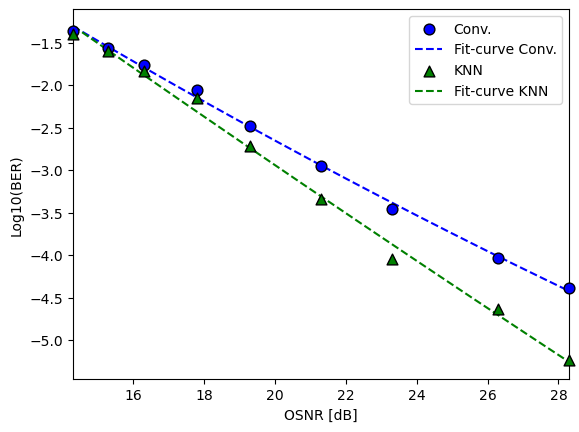

In [11]:
# Fit-curve of the BER
p1 = np.polyfit(OSNR, np.log10(ber), 2)
z1 = np.poly1d(p1)

p2 = np.polyfit(OSNR, np.log10(ber_knn), 2)
z2 = np.poly1d(p2)

x_step = np.linspace(np.min(OSNR), np.max(OSNR), 1000) # step between 4 and 16 dB

# Plot ther BER vs OSNR
plt.scatter(OSNR, np.log10(ber), color='blue', edgecolors='black',
            marker='o', s=60, zorder=3, clip_on=False, label='Conv.')
plt.plot(x_step, z1(x_step), '--b', label='Fit-curve Conv.')

plt.scatter(OSNR, np.log10(ber_knn), color='green', edgecolors='black',
            marker='^', s=60, zorder=3, clip_on=False, label='KNN')
plt.plot(x_step, z2(x_step), '--g', label='Fit-curve KNN')

plt.xlabel('OSNR [dB]')
plt.ylabel('Log10(BER)')
plt.xlim([np.min(OSNR), np.max(OSNR)])
plt.legend()
plt.show()